In [2]:
from utils import *
import array 

from pydub import AudioSegment
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Flatten, GlobalMaxPooling1D, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D, concatenate, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical

from keras.layers import Input, GRU, RepeatVector, BatchNormalization, TimeDistributed, Conv1D
from keras.layers import GlobalAveragePooling1D, LSTM
from keras import backend as K
from keras.layers import  Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape


from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numba

import dask.dataframe as dd
from dask.multiprocessing import get

%matplotlib inline

Using TensorFlow backend.


In [3]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(id2name)

12

In [5]:
%%time 

train_df = pickle.load( open("cache/train_df.pik","rb"))
valid_df = pickle.load( open("cache/valid_df.pik","rb"))
silent_df = pickle.load(open("cache/silent_df.pik","rb"))
unknown_df = pickle.load(open("cache/unknown_df.pik","rb"))
# test_df =  pickle.load(open("cache/test_df.pik","rb"))

CPU times: user 9.86 s, sys: 6.09 s, total: 16 s
Wall time: 1min 4s


In [4]:
filler = AudioSegment.silent(duration=1000, frame_rate = 16000)
silence_files_AS = [AudioSegment.from_wav(x) for x in silent_df.wav_file.values]

In [8]:
def process_wav_file(record, reshape=False, augment=True,pval=0.5 ,output_format='logmel'):
    
    if type(record) == str: # test files
        fname = record
        label = "test"
    else:    
        fname  = record.wav_file
        label = record.label

        
        
        
        
    if "raw_AS_wav" in record: 
        wav = record.raw_AS_wav
    else:
        wav = AudioSegment.from_wav(fname)
        
        
    
    if (not label in ["silence"]) and augment: #no augmentation for sample files 
        wav = augment_wav(wav,pval)

    else: #make sure segment is 1 second
        wav = fill_to_1sec(wav)

        
    samples = AS_to_raw(wav)
    
    
    
    if output_format == "logmel":
        output = log_mel(samples,reshape=reshape)
    else:
        output = samples
    
    
    return output


In [45]:
#no augmentation since the auto encoder has already seen all the train AND test files 

def train_generator(train_batch_size):
    while True:
        
        this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 2000))
        extra_data_size = int(this_train.shape[0]* 0.1)
        this_train = pd.concat([silent_df.sample(extra_data_size),
                                this_train,
                                unknown_df.sample(extra_data_size*4)],axis=0 )
        
        this_train.reset_index(drop=True,inplace=True)
        
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        
        for start in range(0, len(shuffled_ids), train_batch_size):
            x_batch = []
            x_batch_mfcc = []
            x_batch_delta1 = []
            x_batch_delta2 = []
            
            y_batch = []
            
            end = min(start + train_batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
            
            for i in i_train_batch:
                x_batch.append(this_train.loc[i,'raw'].T)
#                 x_batch.append(process_wav_file(this_train.iloc[i], augment=True).T)
                x_batch_mfcc.append(this_train.loc[i,'mfcc'].T)
                x_batch_delta1.append(this_train.loc[i,'delta1'].T)
                x_batch_delta2.append(this_train.loc[i,'delta2'].T)

                y_batch.append(this_train.label_id.values[i])
                
            x_batch = 1.- np.array(x_batch)/-80.
            x_batch_mfcc = np.array(x_batch_mfcc)
            x_batch_delta1 = np.array(x_batch_mfcc)
            x_batch_delta2 = np.array(x_batch_mfcc)
            
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            
            yield [x_batch, x_batch_mfcc,x_batch_delta1,x_batch_delta2], y_batch

In [25]:
%time t = next(train_generator(256))[0]

CPU times: user 92 ms, sys: 0 ns, total: 92 ms
Wall time: 88.4 ms


In [48]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            x_batch_mfcc = []
            x_batch_delta1 = []
            x_batch_delta2 = []
            
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(valid_df.loc[i,'raw'].T)
                x_batch_mfcc.append(valid_df.loc[i,'mfcc'].T)
                x_batch_delta1.append(valid_df.loc[i,'delta1'].T)
                x_batch_delta2.append(valid_df.loc[i,'delta2'].T)                
                
                
                y_batch.append(valid_df.label_id.values[i])

            x_batch = 1.- np.array(x_batch)/-80.
            x_batch_mfcc = np.array(x_batch_mfcc)
            x_batch_delta1 = np.array(x_batch_mfcc)
            x_batch_delta2 = np.array(x_batch_mfcc)

            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield [x_batch, x_batch_mfcc,x_batch_delta1,x_batch_delta2], y_batch

In [205]:
#a common practice is to choose a filter size in time which spans 2/3 o

In [53]:
p = 0.3


In [76]:
def get_conv_stacks( x_in, filter_size=2):
    
#     x = Conv1D(32,filter_size=1,activation='relu')(x_in)
    
    x = Conv1D(32,filter_size,activation='relu')(x_in)
    x = Dropout(p/2)(x)
    x = Conv1D(32,filter_size,activation='relu')(x)
    x = Dropout(p/2)(x)



    # x = LSTM(128,return_sequences=True)(x)

    x = Conv1D(64,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)
    x = Conv1D(64,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)


    # x = LSTM(128,return_sequences=True)(x)

    x = Conv1D(128,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)
    
#     if filter_size < 4: 
#         x = Conv1D(128,filter_size,activation='relu',dilation_rate=2)(x)
#         x = Dropout(p/2)(x)
#         x = Conv1D(128,filter_size,activation='relu',dilation_rate=2)(x)
#         x = Dropout(p/2)(x)
#         x = Conv1D(128,filter_size,activation='relu',dilation_rate=2)(x)
#         x = Dropout(p/2)(x)

    
    x = Conv1D(128,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)
    x = Conv1D(128,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)
    x = Conv1D(128,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)




    x_max = GlobalMaxPooling1D()(x)
    x_avg = GlobalAveragePooling1D()(x)

    x = concatenate([x_max,x_avg])
#     x = Flatten()(x)
    
    return x

In [80]:

timesteps, input_dim , latent_dim = 32,128, 128

x_logmel = Input(shape=(timesteps, input_dim)) #1 channel, 99 time, 161 freqs # S : np.ndarray [shape=(n_mels, t)]

mfcc_input = Input(shape=(timesteps, 40))
delta1_input = Input(shape=(timesteps, 40))
delta2_input = Input(shape=(timesteps, 40))

# x = Reshape((input_dim, timesteps))(x_in)

mfcc  = BatchNormalization()(mfcc_input)
delta1  = BatchNormalization()(delta1_input)
delta2  = BatchNormalization()(delta2_input)

# x = get_conv_stacks(x_in,1)
# x_2 = get_conv_stacks(x_in,2)
# x_3 = get_conv_stacks(x_in,3)

x_1= get_conv_stacks(x_logmel,1)
x_12= get_conv_stacks(x_logmel,2)
x_13= get_conv_stacks(x_logmel,3)

x_2 = get_conv_stacks(mfcc,1)
x_22= get_conv_stacks(mfcc,2)
x_23= get_conv_stacks(mfcc,3)


x_3 = get_conv_stacks(delta1,1)
x_32= get_conv_stacks(delta1,2)
x_33 = get_conv_stacks(delta1,3)


x_4 = get_conv_stacks(delta2,1)
x_42 = get_conv_stacks(delta2,2)
x_43 = get_conv_stacks(delta2,3)


x = concatenate([x_1,x_2,x_3,x_4,
                x_12,x_22,x_32,x_42,
                x_13,x_23,x_33,x_43])


x = Dense(256, activation = 'relu')(x) #
x = Dropout(0.6)(x)

# x = Dense(256, activation = 'relu')(x) #
# x = Dropout(p)(x)

# x = Dense(64, activation = 'relu')(x)
# x = Dropout(0.3)(x)

x = Dense(len(POSSIBLE_LABELS), activation = 'softmax', name='targets')(x)




In [81]:

model = Model(inputs = [x_logmel,mfcc_input,delta1_input,delta2_input], outputs = x)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])



In [83]:
# model.summary()

In [74]:
from keras.callbacks import TensorBoard
exp_name = "dilated_conv_k2_time_extra_mfcc_64_256"
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                              min_lr=1e-6),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')
#              , TensorBoard(log_dir='./logs/logs_{}'.format(exp_name), histogram_freq=0, batch_size=64, write_graph=True)
            ]

Epoch 14/100
300/300 [==============================] - 214s - loss: 0.7612 - acc: 0.7370 - val_loss: 1.0481 - val_acc: 0.6508



Epoch 31/100
350/350 [==============================] - 227s - loss: 0.4294 - acc: 0.8518 - val_loss: 0.9436 - val_acc: 0.7179
Epoch 32/100



Epoch 00058: reducing learning rate to 1.00000006569e-06.
329/329 [==============================] - 191s - loss: 0.7292 - acc: 0.7521 - val_loss: 0.7132 - val_acc: 0.8770


with ae, p=0.
Epoch 28/100
329/329 [==============================] - 7s - loss: 0.3312 - acc: 0.8829 - val_loss: 0.4124 - val_acc: 0.8579

with p=0.4 and /2 for convs 
Epoch 28/100
329/329 [==============================] - 7s - loss: 0.5534 - acc: 0.8056 - val_loss: 0.5074 - val_acc: 0.8312

with p=0.2 and /2
Epoch 00035: reducing learning rate to 1.0000000475e-05.
329/329 [==============================] - 7s - loss: 0.2414 - acc: 0.9137 - val_loss: 0.3686 - val_acc: 0.8811


dilated v1 - p0
Epoch 00010: reducing learning rate to 0.00010000000475.
989/989 [==============================] - 15s - loss: 0.1838 - acc: 0.9389 - val_loss: 0.2511 - val_acc: 0.9261


dilated v1 - p4/2 - lb:0.81
Epoch 28/100
989/989 [==============================] - 17s - loss: 0.3985 - acc: 0.8709 - val_loss: 0.2611 - val_acc: 0.9268

dilated v1 - mix max n avg 
Epoch 31/100
989/989 [==============================] - 17s - loss: 0.3749 - acc: 0.8782 - val_loss: 0.2433 - val_acc: 0.9281

dilated v1 - extra 256 layers x 4
Epoch 35/100
989/989 [==============================] - 30s - loss: 0.4577 - acc: 0.8525 - val_loss: 0.2981 - val_acc: 0.9085


dilated v1 - extra 128 layers x 4 
Epoch 25/100
989/989 [==============================] - 25s - loss: 0.5111 - acc: 0.8372 - val_loss: 0.3371 - val_acc: 0.8971


dilated v2 - conv + lstm 
lb: 0.84
Epoch 30/100
989/989 [==============================] - 92s - loss: 0.1845 - acc: 0.9394 - val_loss: 0.1964 - val_acc: 0.9413


dilated v3 - multiple kernetl sizes: 2 3 4 
Epoch 20/100
989/989 [==============================] - 40s - loss: 0.3161 - acc: 0.8954 - val_loss: 0.3031 - val_acc: 0.9112


dilated v1 - baseline (kernel size 2 only)
Epoch 00026:
989/989 [==============================] - 18s - loss: 0.3169 - acc: 0.8955 - val_loss: 0.2328 - val_acc: 0.9251

dilated v3 - multiple kernetl sizes: 2 3
Epoch 17/100
989/989 [==============================] - 32s - loss: 0.2985 - acc: 0.9017 - val_loss: 0.2113 - val_acc: 0.9342


dilated v1 - baseline (kernel size 1 2 3)
Epoch 22/100
989/989 [==============================] - 42s - loss: 0.2732 - acc: 0.9088 - val_loss: 0.1985 - val_acc: 0.9382


dilated v1 - baseline (kernel size 1 2 3 2x 256)
Epoch 28/100
989/989 [==============================] - 44s - loss: 0.2709 - acc: 0.9103 - val_loss: 0.2183 - val_acc: 0.9342


dilated v1 - baseline (kernel size 1 2 3 2x 128)
Epoch 28/100
Epoch 25/100
989/989 [==============================] - 43s - loss: 0.3238 - acc: 0.8950 - val_loss: 0.2191 - val_acc: 0.9332


dilated v1 + mfcc - kernel 2
Epoch 25/100
197/197 [==============================] - 13s - loss: 0.2159 - acc: 0.9298 - val_loss: 0.2302 - val_acc: 0.9258



dilated v1 + mfcc - kernel 2 - extra input kernel size, final dense 256 p 50
Epoch 26/100
395/395 [==============================] - 21s - loss: 0.1658 - acc: 0.9464 - val_loss: 0.2271 - val_acc: 0.9277


dilated v1 - frequency convs (kernel size 8)
Epoch 19/100
989/989 [==============================] - 40s - loss: 0.2676 - acc: 0.9123 - val_loss: 0.2397 - val_acc: 0.9278



In [75]:
batch_size = 64

history = model.fit_generator(generator=train_generator(batch_size),
                              steps_per_epoch=train_df.shape[0]*(1.2)//batch_size,
                              epochs=100,
                              callbacks=callbacks,
                              validation_data=valid_generator(batch_size),
                              validation_steps=int(np.ceil(valid_df.shape[0]/batch_size)))

Epoch 1/100
395/395 [==============================] - 32s - loss: 1.5517 - acc: 0.4709 - val_loss: 0.8927 - val_acc: 0.7067
Epoch 2/100
395/395 [==============================] - 21s - loss: 0.8060 - acc: 0.7256 - val_loss: 0.5554 - val_acc: 0.8193
Epoch 3/100
395/395 [==============================] - 21s - loss: 0.6095 - acc: 0.7988 - val_loss: 0.4325 - val_acc: 0.8636
Epoch 4/100
395/395 [==============================] - 21s - loss: 0.5198 - acc: 0.8334 - val_loss: 0.3976 - val_acc: 0.8712
Epoch 5/100
395/395 [==============================] - 21s - loss: 0.4461 - acc: 0.8552 - val_loss: 0.3743 - val_acc: 0.8821
Epoch 6/100
395/395 [==============================] - 21s - loss: 0.4178 - acc: 0.8646 - val_loss: 0.3278 - val_acc: 0.8936
Epoch 7/100
395/395 [==============================] - 21s - loss: 0.3884 - acc: 0.8748 - val_loss: 0.3367 - val_acc: 0.8900
Epoch 8/100
395/395 [==============================] - 22s - loss: 0.3604 - acc: 0.8825 - val_loss: 0.3126 - val_acc: 0.8986


In [249]:
model.load_weights('./weights/{}.hdf5'.format(exp_name))

### valid evaluation

In [250]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

In [251]:
val_preds = model.predict_generator(valid_generator(64),steps=int(np.ceil(valid_df.shape[0]/64.)))
val_preds = np.argmax(val_preds,axis=1)

In [252]:
val_preds.shape

(3091,)

In [253]:
oe = OneHotEncoder()

In [254]:
y_true = oe.fit_transform(valid_df.label_id.values.reshape(-1, 1)).todense()



In [255]:
val_preds = oe.transform(val_preds.reshape(-1, 1)).todense()


In [256]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       1.00      0.95      0.97       261
         no       0.91      0.94      0.93       270
         up       0.87      0.95      0.91       260
       down       0.98      0.91      0.94       264
       left       0.94      0.97      0.96       247
      right       0.99      0.93      0.96       256
         on       0.96      0.95      0.95       257
        off       0.95      0.93      0.94       256
       stop       0.99      0.91      0.94       246
         go       0.91      0.88      0.90       260
    silence       0.98      0.99      0.98       257
    unknown       0.82      0.93      0.87       257

avg / total       0.94      0.94      0.94      3091



In [121]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       1.00      0.95      0.97       261
         no       0.95      0.91      0.93       270
         up       0.93      0.92      0.93       260
       down       0.98      0.95      0.96       264
       left       0.95      0.97      0.96       247
      right       0.98      0.91      0.94       256
         on       0.96      0.94      0.95       257
        off       0.91      0.92      0.92       256
       stop       0.99      0.94      0.96       246
         go       0.93      0.92      0.92       260
    silence       0.98      1.00      0.99       257
    unknown       0.77      0.96      0.85       257

avg / total       0.94      0.94      0.94      3091



In [45]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.93      0.96       261
         no       0.90      0.92      0.91       270
         up       0.89      0.94      0.91       260
       down       0.95      0.88      0.91       264
       left       0.94      0.95      0.95       247
      right       0.98      0.94      0.96       256
         on       0.93      0.94      0.94       257
        off       0.94      0.92      0.93       256
       stop       1.00      0.92      0.96       246
         go       0.90      0.87      0.88       260
    silence       0.95      1.00      0.97       257
    unknown       0.78      0.90      0.84       257

avg / total       0.93      0.93      0.93      3091



In [391]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.95      0.94      0.95       261
         no       0.82      0.85      0.84       270
         up       0.89      0.91      0.90       260
       down       0.92      0.88      0.90       264
       left       0.92      0.90      0.91       247
      right       0.97      0.86      0.91       256
         on       0.96      0.86      0.91       257
        off       0.92      0.88      0.90       256
       stop       0.96      0.87      0.91       246
         go       0.86      0.76      0.81       260
    silence       0.98      0.99      0.98       257
    unknown       0.62      0.92      0.74       257

avg / total       0.90      0.89      0.89      3091



In [56]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.93      0.95      0.94       261
         no       0.84      0.81      0.82       270
         up       0.88      0.90      0.89       260
       down       0.83      0.91      0.87       264
       left       0.92      0.88      0.90       247
      right       0.93      0.89      0.91       256
         on       0.89      0.89      0.89       257
        off       0.93      0.86      0.89       256
       stop       0.89      0.89      0.89       246
         go       0.81      0.78      0.79       260
    silence       1.00      1.00      1.00       257
    unknown       0.71      0.78      0.74       257

avg / total       0.88      0.88      0.88      3091



### submission


In [46]:
test_paths = glob(os.path.join('./data/', 'test/audio/*wav'))

In [47]:
len(test_paths)

158538

In [48]:
test_df = pickle.load( open("cache/test_df.pik","rb"))


In [49]:
def test_generator(test_batch_size,augment=False):
    while True:
        ids = list(range(test_df.shape[0]))
        
        for start in range(0, len(ids), test_batch_size):
            x_batch = []
            end = min(start + test_batch_size, len(ids))
            i_test_batch = ids[start:end]
#             this_paths = test_paths[start:end]
#             for x in this_paths:
            for i in i_test_batch:
            #WATCHOUT > NO AUG
#                 x_batch.append(process_wav_file(x).T) #,reshape=False,augment=augment,pval=0.5))
                x_batch.append(test_df.loc[i,'raw'].T)

            x_batch = np.array(x_batch)
            x_batch = 1.- np.array(x_batch)/-80.
            
            yield x_batch

In [257]:
predictions = model.predict_generator(test_generator(256,augment=False), int(np.ceil(len(test_paths)/256.)), verbose=1)

620/620 [==============================] - 9s     


In [258]:
np.save("cache/predictions_{}.npy".format(exp_name),predictions)

In [259]:
predictions.shape

(158538, 12)

#### blending

In [260]:
# predictions_pyramid_noaug = np.load('cache/predictions_pyramid_noaug.npy')
# predictions_model_with_ae_base_drp2_1 = np.load('cache/predictions_model_with_ae_base_drp2_1.npy')
predictions_conv_n_lstm = np.load("cache/predictions_dilated_conv_n_lstm.npy")

In [261]:
predictions = np.mean([predictions,predictions_conv_n_lstm], axis=0)


In [156]:
# num_aug = 2 
# for i in range(num_aug):
#     predictions +=  model.predict_generator(test_generator(64,augment=True), int(np.ceil(len(test_paths)/64.)), verbose=1)
    

# predictions = predictions/(num_aug + 1.0)

2477/2478 [============================>.] - ETA: 0s

#### class assignment

In [262]:
classes = np.argmax(predictions, axis=1)

In [263]:
classes.shape, len(test_paths)

((158538,), 158538)

(array([ 13585.,   6830.,   5294.,   6261.,   5404.,   7593.,   6554.,
          5604.,   7395.,  94018.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

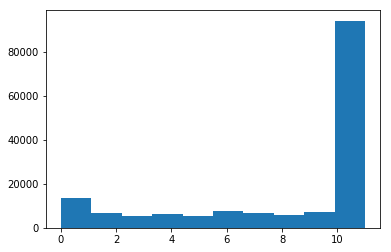

In [264]:
plt.hist(classes,bins=10)

(array([ 13577.,   6145.,   5559.,   6245.,   5493.,   7181.,   6768.,
          5664.,   7460.,  94446.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

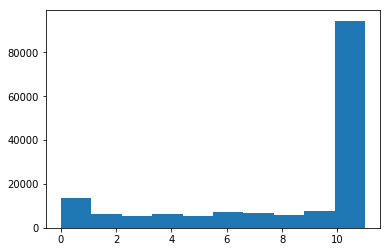

In [128]:
plt.hist(classes,bins=10)

(array([ 14616.,   7273.,   5042.,   6670.,   5905.,  10269.,   7025.,
          5734.,   9826.,  86178.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

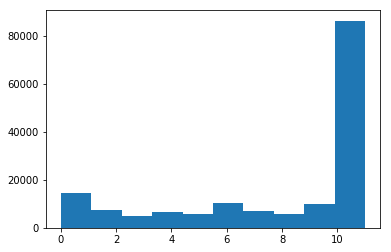

In [55]:
plt.hist(classes,bins=10)

(array([ 12769.,   6288.,   7058.,   6322.,   6488.,   7524.,   5727.,
          6044.,   7517.,  92801.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

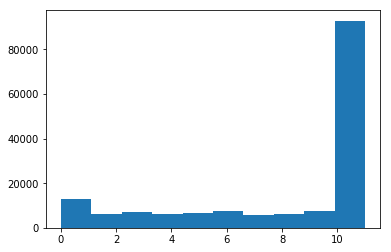

In [411]:
plt.hist(classes,bins=10)

(array([ 12482.,   6260.,   6059.,   6403.,   5591.,   7249.,   6102.,
          6070.,   7064.,  95258.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

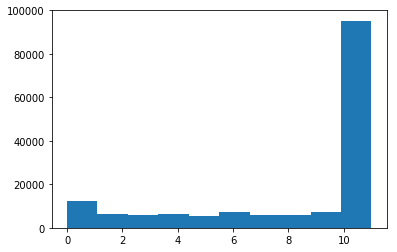

In [403]:
plt.hist(classes,bins=10)

(array([ 13909.,   6442.,  10015.,   6507.,   8567.,   8867.,   5738.,
          6198.,   9714.,  82581.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

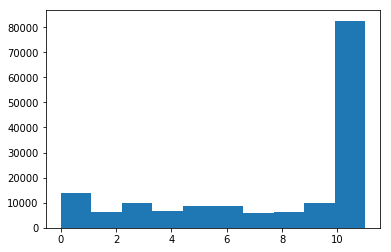

In [69]:
plt.hist(classes,bins=10)

(array([ 14037.,   7124.,  12571.,   6486.,  10360.,  11502.,   6549.,
          6624.,  10275.,  73010.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

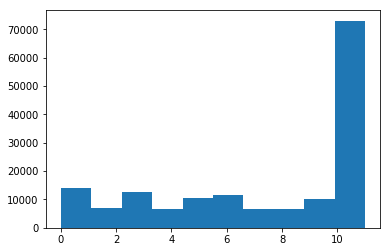

In [122]:
plt.hist(classes,bins=10)

### blending

### submission

In [265]:
### last batch will contain padding, so remove duplicates
submission = dict()
for i in range(len(test_paths)):
    fname, label = os.path.basename(test_paths[i]), id2name[classes[i]]
    submission[fname] = label

In [266]:
with open('subm/submission_{}_.csv'.format(exp_name), 'w') as fout:
    fout.write('fname,label\n')
    for fname, label in submission.items():
        fout.write('{},{}\n'.format(fname, label))

In [267]:
from IPython.lib.display import FileLink

FileLink('subm/submission_{}_blend_convnlstm.csv'.format(exp_name))


/home/ubuntu/keyword_spotting/subm/submission_dilated_conv_varying_filter_size123_blend_convnlstm.csv